# Rapid Research Report 1 - Forest Fires
### Trinity Gahagen
---
---

This notebook will deviate from the typical rapid EDAs showcased in the repository. Instead of being timed for only 1-2 hours, this notebook was curated over the course of 12+ hours and created with a focus on employing/improving machine learning models.


Dataset: https://www.kaggle.com/datasets/elikplim/forest-fires-data-set/data

## Dataset Overview
---
From the Kaggle page and research paper it references [Cortez and Morais, 2007], the features in this dataset are:

| Feature |           Description                  |
|---------|----------------------------------------|
|X| x-axis spatial coordinate within the Montesinho park map: 1 to 9 |
|Y| y-axis spatial coordinate within the Montesinho park map: 2 to 9 |
|month| month of the year "jan" to "dec"|
|day| day of the week "mon" to "sun"|
|FFMC| FFMC index from the FWI system 18.7 to 96.20|
|DMC| DMC index from the FWI system 1.1 to 291.3|
|DC| DC index from the FWI system 7.9 to 860.6|
|ISI| ISI index from the FWI system| 0.0 to 56.10|
|temp| temperature in Celsius degrees: 2.2 to 33.30
|RH| relative humidity in % 15.0 to 100|
|wind| wind speed in km/h: 0.40 to 9.40|
|rain| outside rain in mm/m2 : 0.0 to 6.4|
|area| the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).|


`FFMC` - Fine Fuel Moisture Code<br>
>FFMC denotes the moisture content surface litter and influences and fire spread<br>

`DMC` - Duff Moisture Code<br>
`DC` - Drought Code<br>

>the DMC and DC represent the moisture content of shallow and deep organic layers, which affect fire intensity<br>

`ISI` - Initial Spread Index<br>
>a score that correlates with fire velocity spread<br>

### Imports

In [487]:
# System and Operational Importations
import sys, os

# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Plot specifications
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titleweight'] = 'bold'

# Machine Learning tools and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

# Machine Learning models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [426]:
forest_fires = pd.read_csv('../data/forestfires.csv')

### Initial Data Exploration

In [427]:
forest_fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [428]:
forest_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [429]:
forest_fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [430]:
forest_fires.describe(include="O")

,month,day
count,517,517
unique,12,7
top,aug,sun
freq,184,95


Categorical Variables: X, Y, month, day

Numerical Variables: FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

Target Variable: area

In [431]:
forest_fires.duplicated().sum()

4

In [432]:
forest_fires.drop_duplicates(inplace=True)

## Exploratory Data Analysis: Descriptive Analysis
---

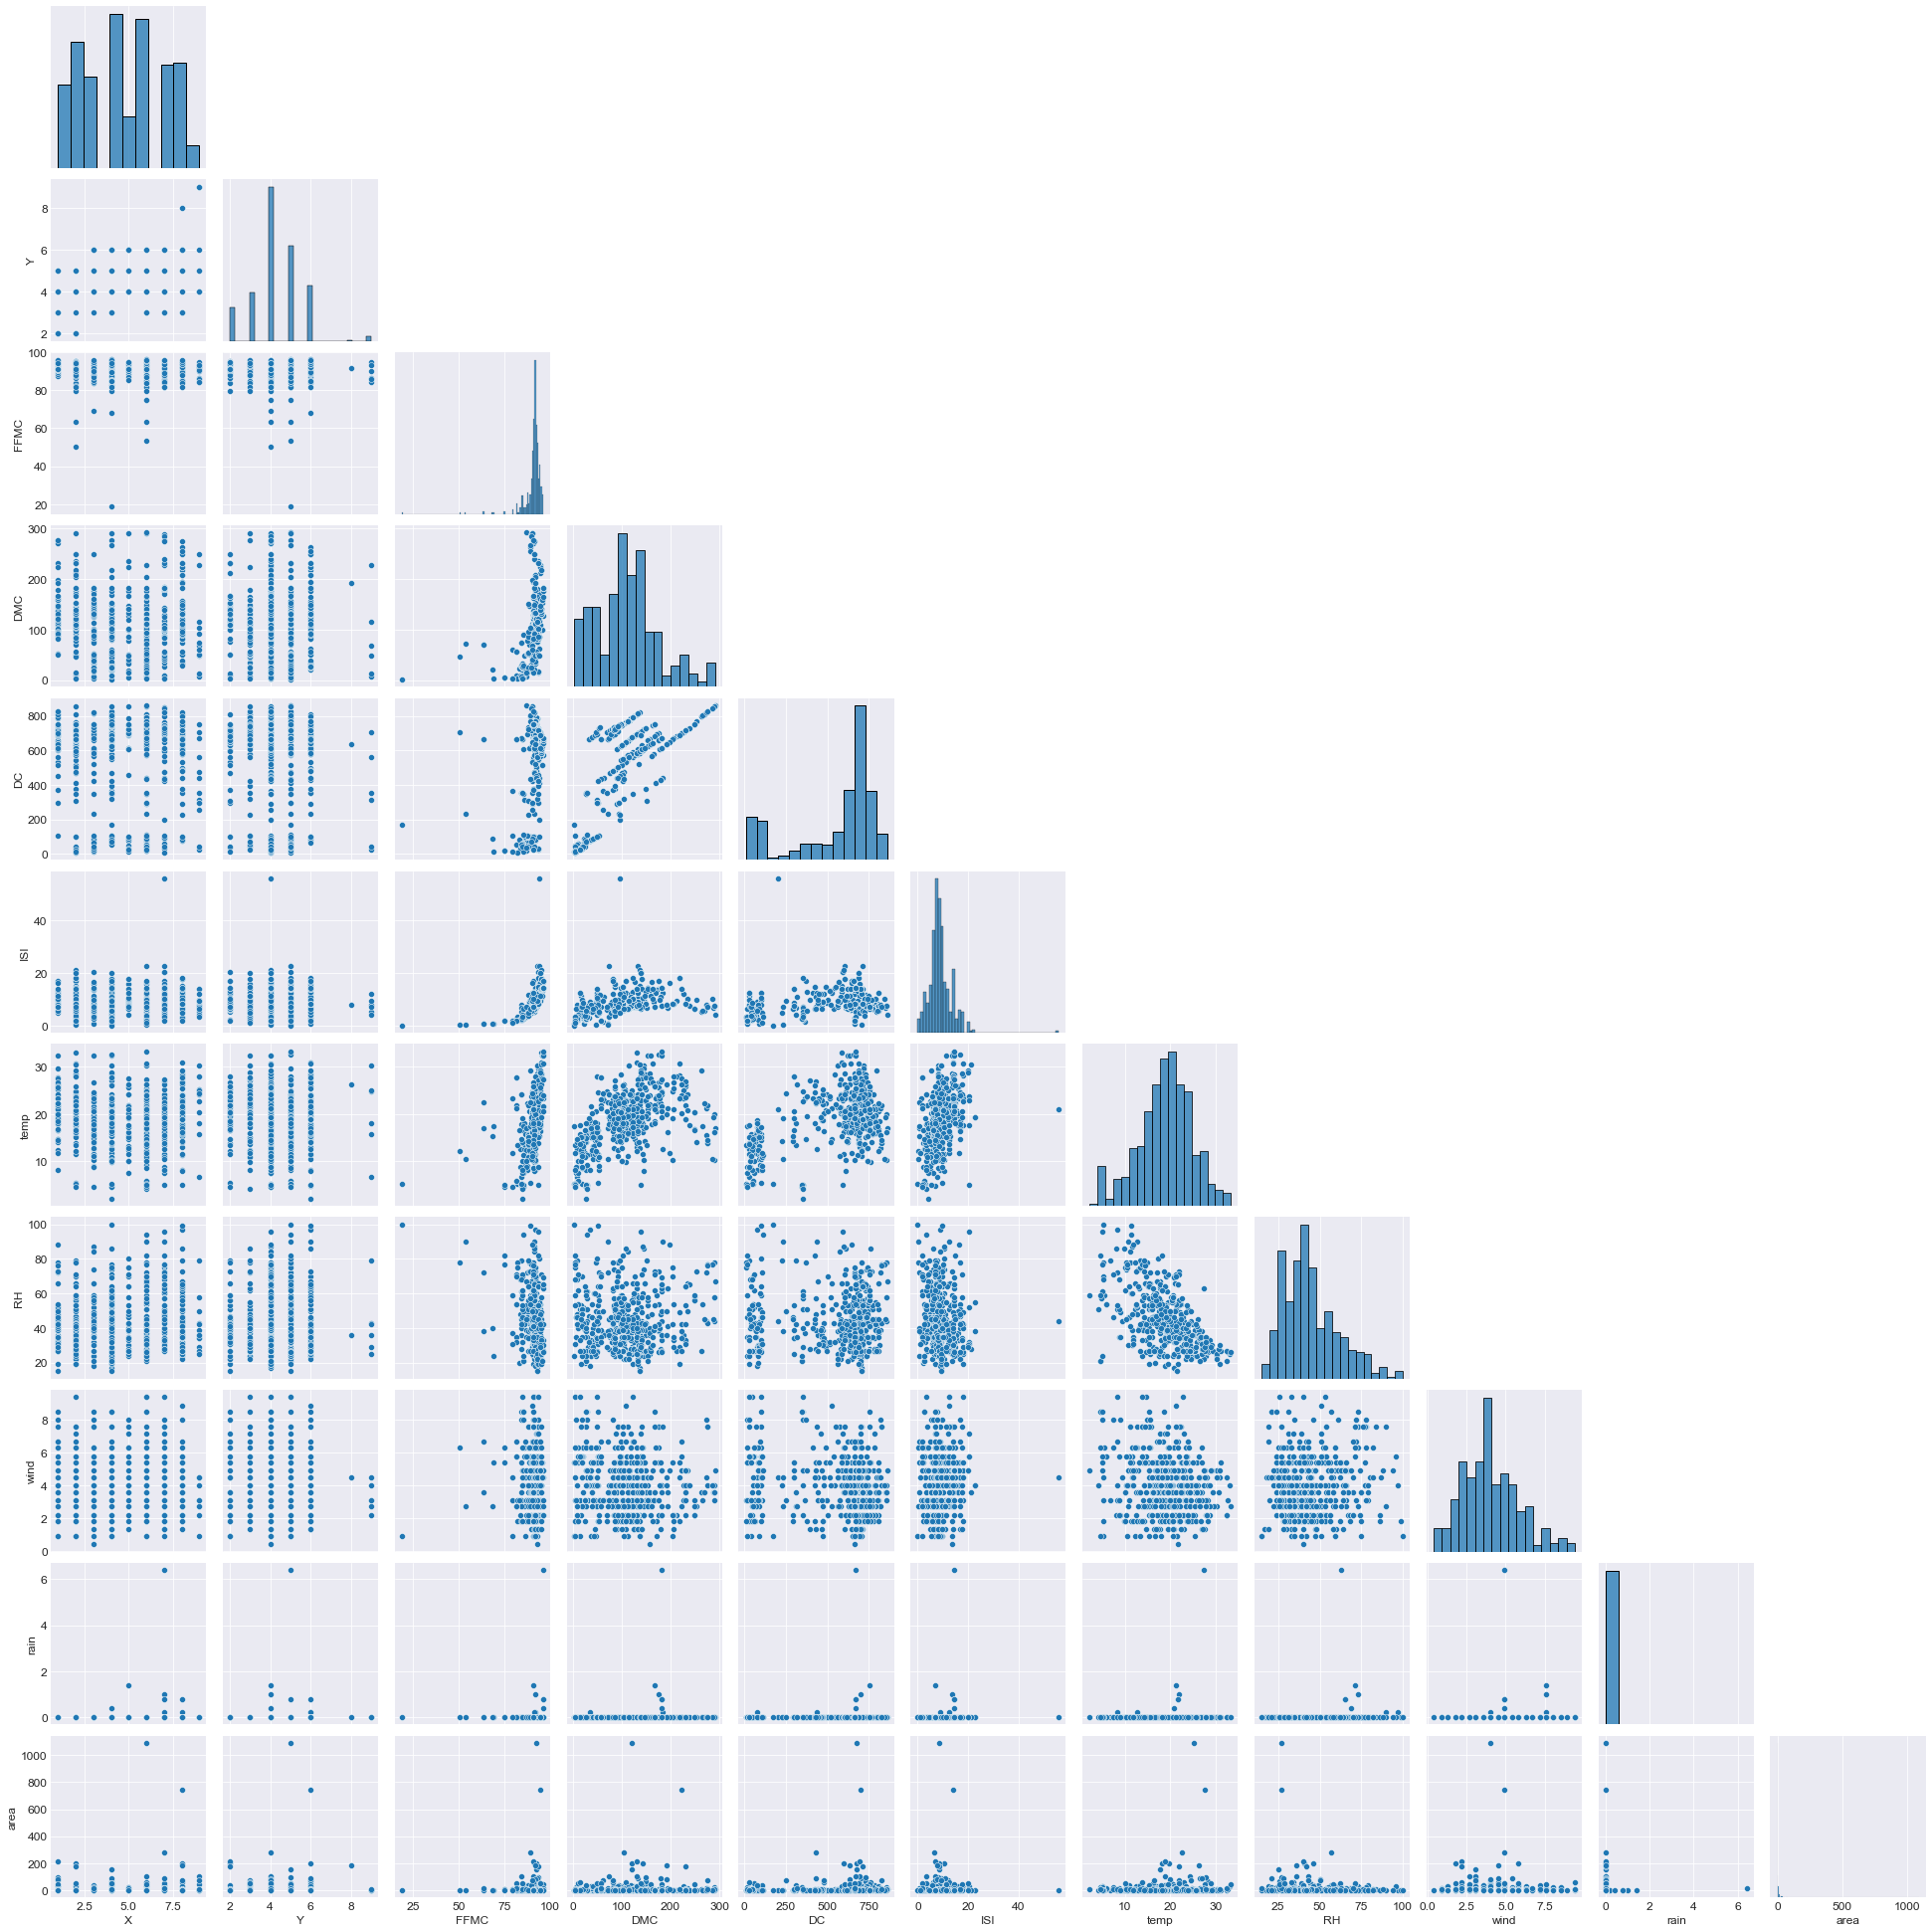

In [433]:
sns.pairplot(data=forest_fires, palette='rocket', corner=True);

**Observations**: The numerical fire-specific variables (FFMC, DMC, DC, and ISI) unsurprisingly have some sort of relationship to one another, and temperature seems to be correlated with these variables as well. FFMC is exponentially associated with ISI since ISI is composed of FFMC and wind. For FMCC, DMC, and DC, according to Cortez and Morais,

> Although different scales are used for each of the FWI elements, high values suggest more severe burning conditions. Also,the fuel moisture codes require a memory (time lag) of past weather conditions: 16hours for FFMC, 12 days for DMC and 52 days for DC.

It is difficult to tell if there is any correlation of variables with area because the distribution is so skewed towards 0. As the kaggle page suggests, we will use a logarithmic transform to grasp a better understanding of area.

In [434]:
forest_fires['log_area'] = np.log(forest_fires['area'] + 1)
forest_fires['log_area'].describe()


count    513.000000
mean       1.113081
std        1.397685
min        0.000000
25%        0.000000
50%        0.431782
75%        2.024193
max        6.995620
Name: log_area, dtype: float64

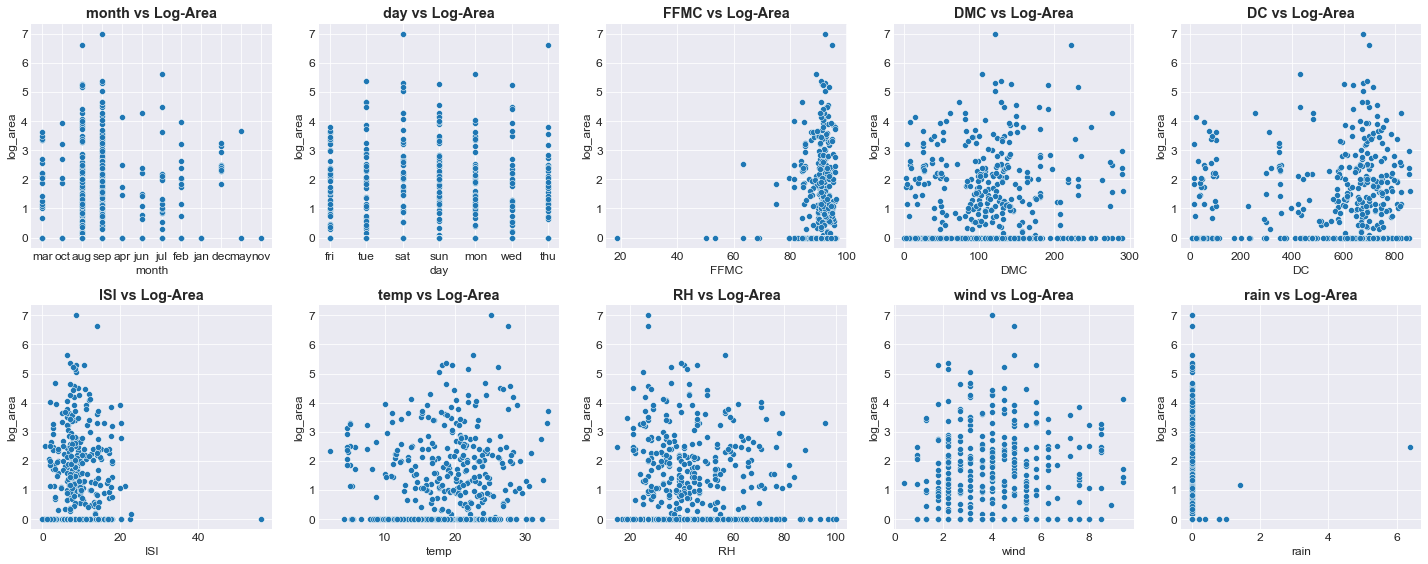

In [435]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for n, col in enumerate(forest_fires.drop(columns=['X', 'Y', 'area', 'log_area']).columns):
    ax_n = ax[n // 5][n % 5]
    
    sns.scatterplot(data=forest_fires, x=col, y='log_area', ax=ax_n)
    ax_n.set_title(f'{col} vs Log-Area')
plt.tight_layout()

There appears to be a higher concentration of observations in the months of August and September. There is also unsurprisingly a higher concentration of fires when there is no rain. More destructive fires occur when FFMC is high, but when ISI is low. DMC has a higher concentration of destructive fires in values between 50 and 150, while DC has this in values between 600 and 800. There is very little correlation between the log of area burned and temperature, wind, and relative humidity.

### Descriptive Analysis: Question
Which areas of the park tend to have more hectares burned?

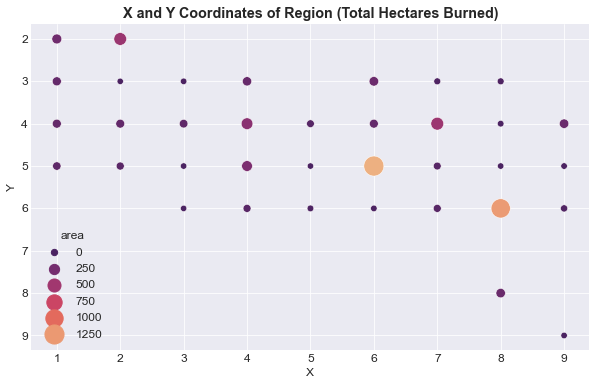

In [436]:
plt.figure(figsize=(10, 6))

fires_map = forest_fires.groupby(['X', 'Y'], as_index=False)['area'].sum()

sns.scatterplot(data=fires_map, x='X', y='Y', hue='area', size='area', palette='flare_r', sizes=(40, 400))
plt.gca().invert_yaxis()
plt.title('X and Y Coordinates of Region (Total Hectares Burned)');

The south-eastern section, particularly in quadrants (6, 5) and (8, 6), appear to suffer the most damage of all the areas from all time.

### Descriptive Analysis: Question
What is the relationship between FMCC and ISI? How many destructive fires occur when these values increase?

In [437]:
def create_scatter_with_hue(dataset, x, y, hue):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=dataset, x=x, y=y, hue=hue, palette='flare_r')
    plt.title(f'{x} vs. {y}');

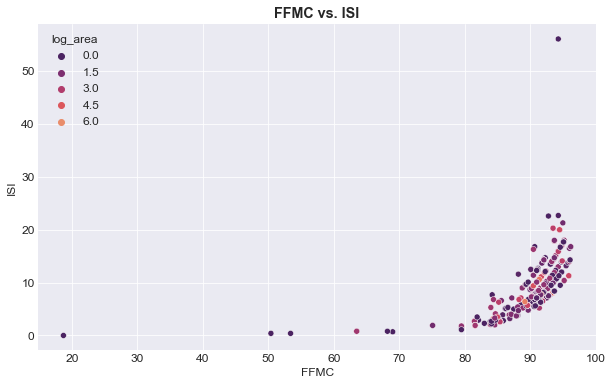

In [438]:
create_scatter_with_hue(forest_fires, x='FFMC', y='ISI', hue='log_area')

There's a small, positive exponential curve when plotting FFMC vs. ISI, and the log(area) burned does not show a very clear pattern.

In [439]:
forest_fires.loc[forest_fires['ISI'] > 50]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.0,0.0


The above observation is the lone outlier point in the plot above. I am not sure why the value of ISI is so high compared to the rest of the dataset.

### Descriptive Analysis: Question
What is the relationship between FMCC and wind? How many destructive fires occur when these values increase?

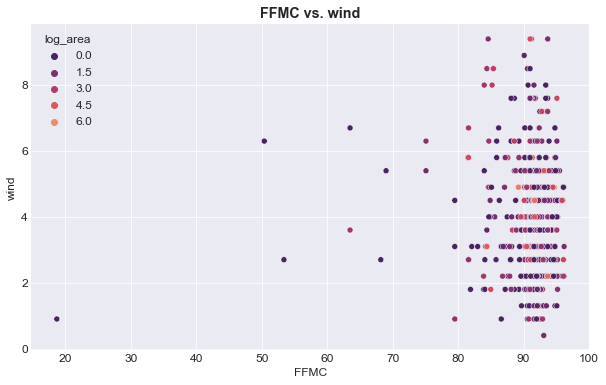

In [440]:
create_scatter_with_hue(forest_fires, x='FFMC', y='wind', hue='log_area')

Similarly to the plot above, it's hard to distinguish any kind of pattern between the destructive fires and the FMCC/wind relationship. There doesn't even really appear to be a clear relationship between FMCC and wind.

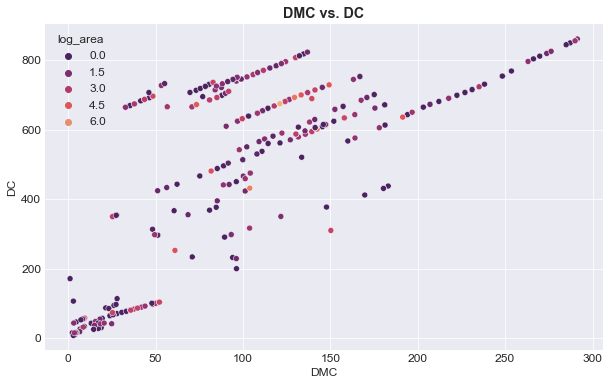

In [441]:
create_scatter_with_hue(forest_fires, x='DMC', y='DC', hue='log_area')

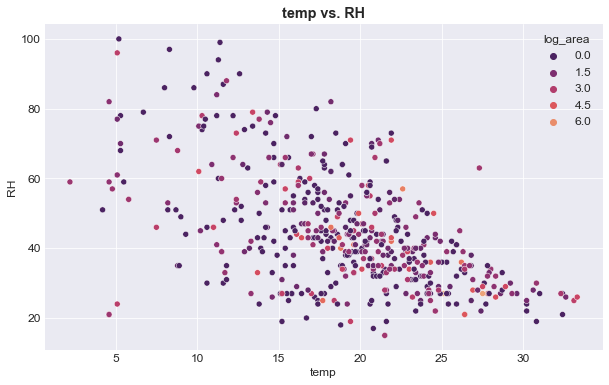

In [442]:
create_scatter_with_hue(forest_fires, x='temp', y='RH', hue='log_area')

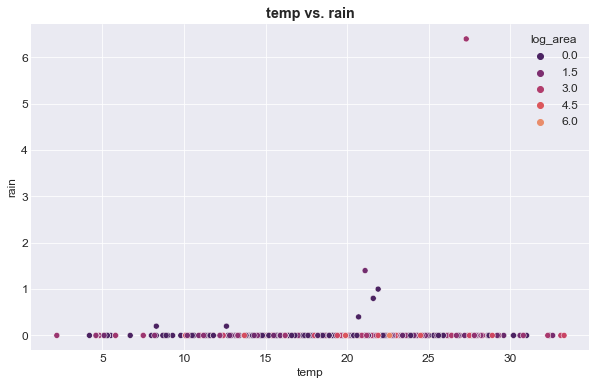

In [443]:
create_scatter_with_hue(forest_fires, x='temp', y='rain', hue='log_area')

In [444]:
forest_fires['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [445]:
months = [
    'jan',
    'feb',
    'mar',
    'apr',
    'may',
    'jun',
    'jul',
    'aug',
    'sep',
    'oct',
    'nov',
    'dec'
]
forest_fires['month'] = pd.Categorical(forest_fires['month'], categories=months, ordered=True)

days = [
    'sun',
    'mon',
    'tue',
    'wed',
    'thu',
    'fri',
    'sat'
]
forest_fires['day'] = pd.Categorical(forest_fires['day'], categories=days, ordered=True)


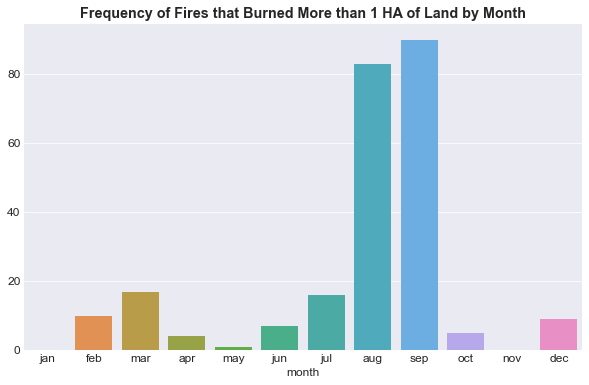

In [446]:
FIRES = forest_fires['area'] > 1
fires_by_month = forest_fires[FIRES].groupby('month').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_month.index, y=fires_by_month)
plt.title('Frequency of Fires that Burned More than 1 HA of Land by Month');

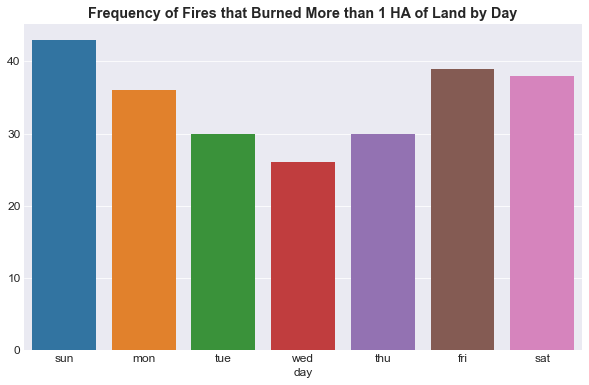

In [447]:
FIRES = forest_fires['area'] > 1
fires_by_day = forest_fires[FIRES].groupby('day').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_day.index, y=fires_by_day)
plt.title('Frequency of Fires that Burned More than 1 HA of Land by Day');

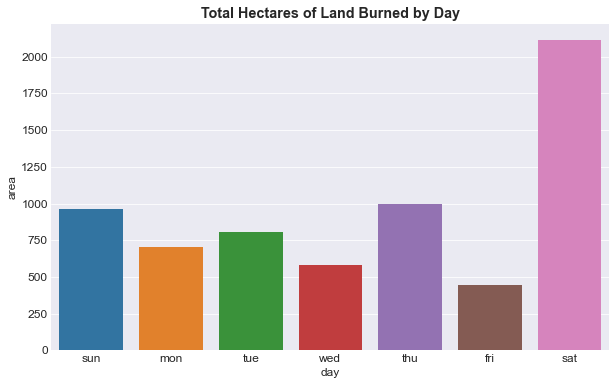

In [448]:
FIRES = forest_fires['area'] > 0
fires_by_day = forest_fires[FIRES].groupby('day')['area'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_day.index, y=fires_by_day)
plt.title('Total Hectares of Land Burned by Day');

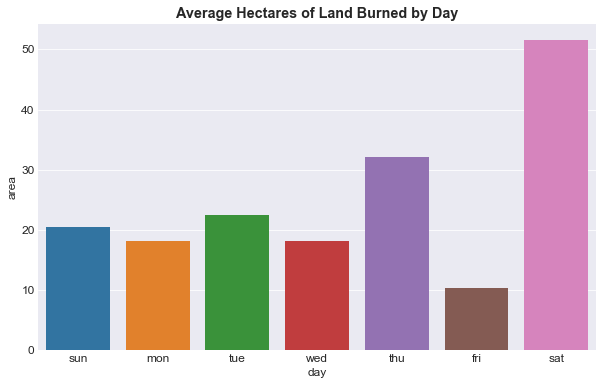

In [449]:
FIRES = forest_fires['area'] > 0
fires_by_day = forest_fires[FIRES].groupby('day')['area'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_day.index, y=fires_by_day)
plt.title('Average Hectares of Land Burned by Day');

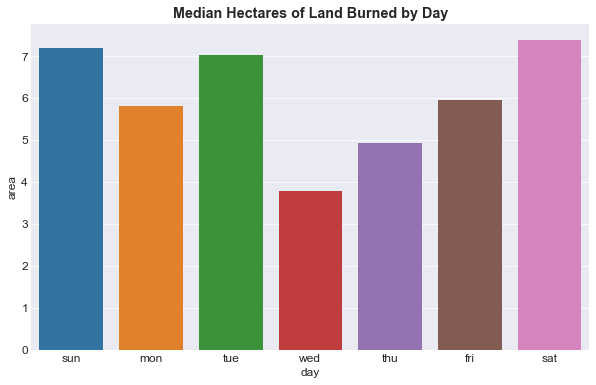

In [450]:
FIRES = forest_fires['area'] > 0
fires_by_day = forest_fires[FIRES].groupby('day')['area'].median()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_day.index, y=fires_by_day)
plt.title('Median Hectares of Land Burned by Day');

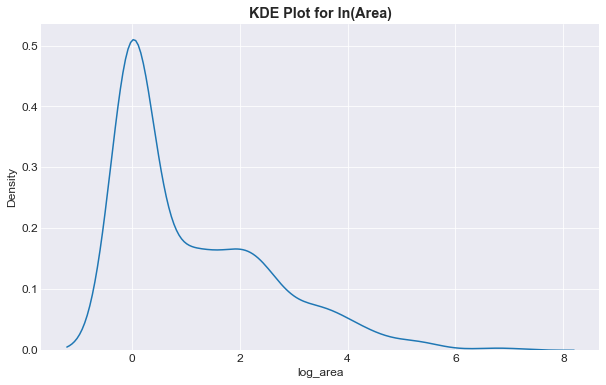

In [451]:
plt.figure(figsize=(10, 6))
sns.kdeplot(forest_fires['log_area'])
plt.title('KDE Plot for ln(Area)');

It appears there is a high frequency of fires with little to no damage, and the frequency decreases for fires with higher damage.

In [452]:
# Split area into categorical variables: No damage, low damage, high damage, catastrophic damage
def area_mapper(log_area):
    if log_area == 0:
        return "None"
    elif 0 < log_area < 2: # This is one square mile's worth of damage
        return "Low"
    elif 2 <= log_area < 4: # I arbitrarily chose this, since 2.3 sq. mi. seems like a high enough threshold
        return "High"
    else:
        return "Catastrophic"

In [453]:
forest_fires['damage_type'] = forest_fires['log_area'].map(area_mapper)

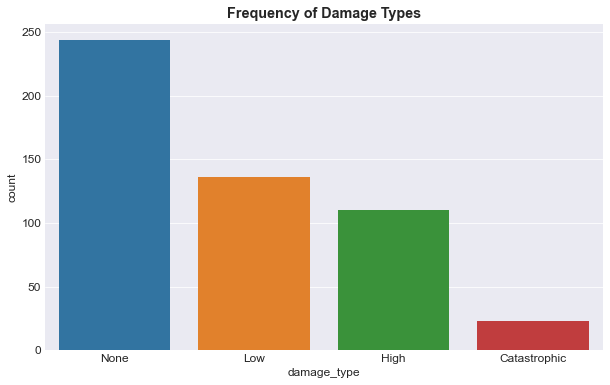

In [454]:
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_fires['damage_type'].value_counts().index, y=forest_fires['damage_type'].value_counts())
plt.title('Frequency of Damage Types');

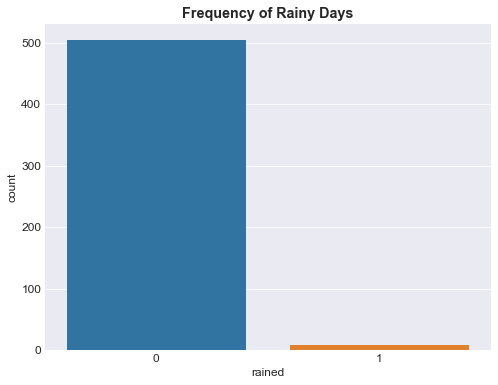

In [455]:
# I want to create a column that just indicated whether it did rain or not
forest_fires['rained'] = forest_fires['rain'].map(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(8, 6))
sns.countplot(forest_fires['rained'])
plt.title('Frequency of Rainy Days');

### Key observations:
---
- There are a very sparse number of fires that did an excessive amount of damage.
- A little less than half of the observations in this dataset did not result in any damage at all.
- The most fires occurred in August and September
- There is a very sparse number of days where it actually rained.

## Exploratory Data Analysis: Inferential Analysis
---

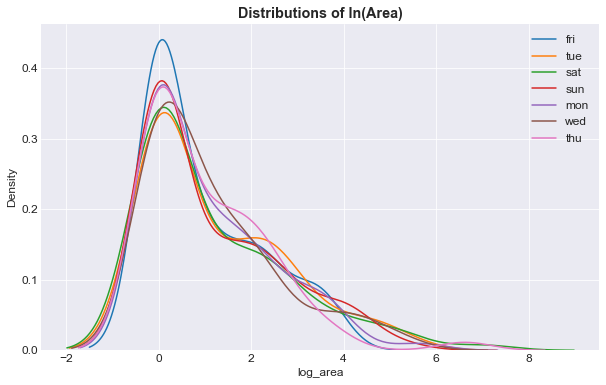

In [456]:
colors = sns.color_palette('tab10')
plt.figure(figsize=(10, 6))
for n, day in enumerate(forest_fires['day'].unique()):
    day_of_week = forest_fires[forest_fires['day'] == day]
    sns.kdeplot(x=day_of_week['log_area'], color=colors[n], label=day)
plt.legend()
plt.title('Distributions of ln(Area)');

In [457]:
day_dists = []
for day in forest_fires['day'].unique():
    day_dist = forest_fires.loc[forest_fires['day'] == day, 'log_area']
    day_dists.append(day_dist)
    _, p_val = stats.shapiro(day_dist)
    if p_val < 0.05:
        print(f'{day} distribution is probably not normal')
    else:
        print(f'{day} distribution is probably normal')

fri distribution is probably not normal
tue distribution is probably not normal
sat distribution is probably not normal
sun distribution is probably not normal
mon distribution is probably not normal
wed distribution is probably not normal
thu distribution is probably not normal


$H_0$: The medians of ln(area) for each day of the week is the same.

$H_a$: The medians of ln(area) for each day of the week is *not* the same.

We will test this with a 0.05 significance level.

In [458]:
_, p_val = stats.kruskal(*day_dists)

if p_val < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


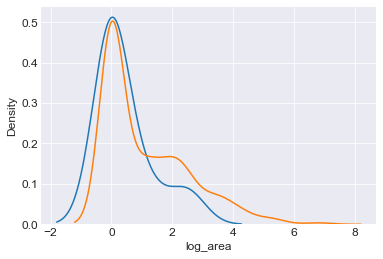

In [459]:
RAINED = forest_fires['rained'] == 1

sns.kdeplot(forest_fires.loc[RAINED, 'log_area'], label='Rained')
sns.kdeplot(forest_fires.loc[~RAINED, 'log_area'], label='Did not rain');

$H_0$: The distribution of ln(area) is the same for when it rained as when it did not rain.

$H_a$: The distribution of ln(area) is *not* the same for when it rained as when it did not rain.

We will test this with a 0.05 significance level.

In [460]:
_, p_val = stats.mannwhitneyu(forest_fires.loc[RAINED, 'log_area'], forest_fires.loc[~RAINED, 'log_area'])

if p_val < 0.05:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


Because both of the above hypothesis tests failed, it indicates that the features `day`, `rain`, and `rained` may not contain much signal and may not be relevant to keep in the final feature set when creating a machine learning model. This will be kept in mind for further investigation.

## Data Preprocessing
---

In [461]:
forest_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 516
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   X            513 non-null    int64   
 1   Y            513 non-null    int64   
 2   month        513 non-null    category
 3   day          513 non-null    category
 4   FFMC         513 non-null    float64 
 5   DMC          513 non-null    float64 
 6   DC           513 non-null    float64 
 7   ISI          513 non-null    float64 
 8   temp         513 non-null    float64 
 9   RH           513 non-null    int64   
 10  wind         513 non-null    float64 
 11  rain         513 non-null    float64 
 12  area         513 non-null    float64 
 13  log_area     513 non-null    float64 
 14  damage_type  513 non-null    object  
 15  rained       513 non-null    int64   
dtypes: category(2), float64(9), int64(4), object(1)
memory usage: 61.9+ KB


I might want to try this problem as a classification problem and a regression problem and see which one will yield better results. I will preprocess and separate the data accordingly.

In [462]:
# I will encode each region by its (X, Y) coordinates
forest_fires['region'] = forest_fires.apply(lambda row: "(" + str(row.X) + ", " + str(row.Y) + ")", axis=1)

region_mapper = {}
for n, index in enumerate(forest_fires['region'].unique()):
    region_mapper[index] = n

forest_fires['region'] = forest_fires['region'].map(region_mapper)
forest_fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,damage_type,rained,region
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,None,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,None,0,1
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,None,0,1
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,None,1,2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,None,0,2


In [463]:
forest_fires['region'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int64)

In [464]:
damage_labels = {"None": 0, "Low": 1, "High": 2, "Catastrophic":3}
forest_fires['damage_type'] = forest_fires['damage_type'].map(damage_labels)

In [465]:
try:
    forest_fires.drop(columns=['X', 'Y'], inplace=True)
except:
    print("Columns already dropped")

In [466]:
# Create a dataset with one-hot encoded columns rather than label encoded columns
onehot_data = pd.get_dummies(forest_fires, columns=['month', 'day', 'region'], dtype=int, drop_first=True)
onehot_data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,...,region_26,region_27,region_28,region_29,region_30,region_31,region_32,region_33,region_34,region_35
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [471]:
month_labels = {month: num for num, month in enumerate(months)}
day_labels = {day: num for num, day in enumerate(days)}

label_data = forest_fires.copy()

label_data['month'] = label_data['month'].map(month_labels)
label_data['day'] = label_data['day'].map(day_labels)

label_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,damage_type,rained,region
0,2,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,0,0,0
1,9,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,0,0,1
2,9,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,0,0,1
3,2,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,0,1,2
4,2,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,0,0,2


## Machine Learning: Models

In [472]:
onehot_X = onehot_data.drop(columns=['damage_type','log_area', 'area'])
onehot_y = onehot_data['damage_type']

label_X = label_data.drop(columns=['damage_type','log_area', 'area'])
label_y = label_data['damage_type']

Models that work well with many features:
- Naive Bayes/Gaussian Bayes

Models that are affected by the curse of dimensionality:
- Pretty much every other one that I know of???

In [488]:
onehot_models = {
    "KNN": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('lda', LDA()),
            ('knn', KNeighborsClassifier())
            ]),
        },
    "SVM": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('lda', LDA()),
            ('svc', SVC())
            ]),
        },
    "RANDFOREST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', RandomForestClassifier())
            ]),
        },
    "NB": {
        "Estimator": Pipeline(steps=[
            #('scaler', StandardScaler()),
            ('nb', GaussianNB())
            ]),
        },
    "ADA": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        },
    "GBOOST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        }
}

for name in onehot_models:
    onehot_models[name]["All_Scores"] = list()
    onehot_models[name]["Top_Score"] = float()
    onehot_models[name]["Mean_Score"] = float()
    onehot_models[name]["Std_Score"] = float()

In [489]:
NUM_FOLDS, SCORING = 10, "accuracy"

for name in onehot_models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    results = cross_val_score(estimator=onehot_models[name]["Estimator"],
                              X=onehot_X,
                              y=onehot_y,
                              cv=folds,
                              scoring=SCORING)

    onehot_models[name]["Top_Score"] = results.max()
    onehot_models[name]["Mean_Score"] = results.mean()
    onehot_models[name]["Std_Score"] = results.std()

    for result in results:
        onehot_models[name]["All_Scores"].append(result)

In [490]:
for name in onehot_models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance: \t\t{:.4f}".format(onehot_models[name]["Top_Score"]))
    print(">>>> Average Performance: \t{:.4f}".format(onehot_models[name]["Mean_Score"]))
    print(">>>> Spread of Performance: \t{:.4f}".format(onehot_models[name]["Std_Score"]))


[MODEL TYPE: KNN]

>>>> Top Performance: 		0.4706
>>>> Average Performance: 	0.3356
>>>> Spread of Performance: 	0.0794

[MODEL TYPE: SVM]

>>>> Top Performance: 		0.5490
>>>> Average Performance: 	0.3882
>>>> Spread of Performance: 	0.1253

[MODEL TYPE: RANDFOREST]

>>>> Top Performance: 		0.5385
>>>> Average Performance: 	0.3641
>>>> Spread of Performance: 	0.1127

[MODEL TYPE: NB]

>>>> Top Performance: 		0.3137
>>>> Average Performance: 	0.2166
>>>> Spread of Performance: 	0.0852

[MODEL TYPE: ADA]

>>>> Top Performance: 		0.5098
>>>> Average Performance: 	0.3571
>>>> Spread of Performance: 	0.0838

[MODEL TYPE: GBOOST]

>>>> Top Performance: 		0.5098
>>>> Average Performance: 	0.3571
>>>> Spread of Performance: 	0.0838


In [491]:
label_models = {
    "KNN": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('lda', LDA()),
            ('knn', KNeighborsClassifier())
            ]),
        },
    "SVM": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('lda', LDA()),
            ('svc', SVC())
            ]),
        },
    "RANDFOREST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', RandomForestClassifier())
            ]),
        },
    "LOGREG": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression())
            ]),
        },
    "ADA": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        },
    "GBOOST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        }
}

for name in label_models:
    label_models[name]["All_Scores"] = list()
    label_models[name]["Top_Score"] = float()
    label_models[name]["Mean_Score"] = float()
    label_models[name]["Std_Score"] = float()

In [492]:
NUM_FOLDS, SCORING = 10, "accuracy"

for name in label_models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    results = cross_val_score(estimator=label_models[name]["Estimator"],
                              X=label_X,
                              y=label_y,
                              cv=folds,
                              scoring=SCORING)

    label_models[name]["Top_Score"] = results.max()
    label_models[name]["Mean_Score"] = results.mean()
    label_models[name]["Std_Score"] = results.std()

    for result in results:
        label_models[name]["All_Scores"].append(result)

In [493]:
for name in label_models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance: \t\t{:.4f}".format(label_models[name]["Top_Score"]))
    print(">>>> Average Performance: \t{:.4f}".format(label_models[name]["Mean_Score"]))
    print(">>>> Spread of Performance: \t{:.4f}".format(label_models[name]["Std_Score"]))


[MODEL TYPE: KNN]

>>>> Top Performance: 		0.5490
>>>> Average Performance: 	0.3883
>>>> Spread of Performance: 	0.0820

[MODEL TYPE: SVM]

>>>> Top Performance: 		0.5882
>>>> Average Performance: 	0.4700
>>>> Spread of Performance: 	0.0483

[MODEL TYPE: RANDFOREST]

>>>> Top Performance: 		0.5686
>>>> Average Performance: 	0.3660
>>>> Spread of Performance: 	0.1269

[MODEL TYPE: LOGREG]

>>>> Top Performance: 		0.5098
>>>> Average Performance: 	0.4465
>>>> Spread of Performance: 	0.0408

[MODEL TYPE: ADA]

>>>> Top Performance: 		0.4510
>>>> Average Performance: 	0.3408
>>>> Spread of Performance: 	0.0777

[MODEL TYPE: GBOOST]

>>>> Top Performance: 		0.4510
>>>> Average Performance: 	0.3408
>>>> Spread of Performance: 	0.0777


Every single model is doing really terribly. They're all just guessing.

Let's try messing around with different features.

In [494]:
forest_fires.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 516
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   month        513 non-null    category
 1   day          513 non-null    category
 2   FFMC         513 non-null    float64 
 3   DMC          513 non-null    float64 
 4   DC           513 non-null    float64 
 5   ISI          513 non-null    float64 
 6   temp         513 non-null    float64 
 7   RH           513 non-null    int64   
 8   wind         513 non-null    float64 
 9   rain         513 non-null    float64 
 10  area         513 non-null    float64 
 11  log_area     513 non-null    float64 
 12  damage_type  513 non-null    int64   
 13  rained       513 non-null    int64   
 14  region       513 non-null    int64   
dtypes: category(2), float64(9), int64(4)
memory usage: 57.8 KB


In [499]:
forest_fires['damage'] = forest_fires['damage_type'].map(lambda x: 0 if x == 0 else 1)

In [503]:
X = forest_fires[['FFMC', 'DMC', 'ISI', 'temp', 'wind', 'rained']]
y = forest_fires['damage']

In [504]:
lessfeat_models = {
    "KNN": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            #('lda', LDA()),
            ('knn', KNeighborsClassifier())
            ]),
        },
    "SVM": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            #('lda', LDA()),
            ('svc', SVC())
            ]),
        },
    "RANDFOREST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', RandomForestClassifier())
            ]),
        },
    "NB": {
        "Estimator": Pipeline(steps=[
            #('scaler', StandardScaler()),
            ('nb', GaussianNB())
            ]),
        },
    "ADA": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        },
    "GBOOST": {
        "Estimator": Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('randforest', AdaBoostClassifier())
            ]),
        }
}

for name in lessfeat_models:
    lessfeat_models[name]["All_Scores"] = list()
    lessfeat_models[name]["Top_Score"] = float()
    lessfeat_models[name]["Mean_Score"] = float()
    lessfeat_models[name]["Std_Score"] = float()

In [505]:
NUM_FOLDS, SCORING = 10, "accuracy"

for name in lessfeat_models:
    folds = StratifiedKFold(n_splits=NUM_FOLDS)
    results = cross_val_score(estimator=lessfeat_models[name]["Estimator"],
                              X=X,
                              y=y,
                              cv=folds,
                              scoring=SCORING)

    lessfeat_models[name]["Top_Score"] = results.max()
    lessfeat_models[name]["Mean_Score"] = results.mean()
    lessfeat_models[name]["Std_Score"] = results.std()

    for result in results:
        lessfeat_models[name]["All_Scores"].append(result)

In [506]:
for name in lessfeat_models:
    print("\n[MODEL TYPE: {}]\n".format(name))
    print(">>>> Top Performance: \t\t{:.4f}".format(lessfeat_models[name]["Top_Score"]))
    print(">>>> Average Performance: \t{:.4f}".format(lessfeat_models[name]["Mean_Score"]))
    print(">>>> Spread of Performance: \t{:.4f}".format(lessfeat_models[name]["Std_Score"]))


[MODEL TYPE: KNN]

>>>> Top Performance: 		0.4706
>>>> Average Performance: 	0.4464
>>>> Spread of Performance: 	0.0186

[MODEL TYPE: SVM]

>>>> Top Performance: 		0.7255
>>>> Average Performance: 	0.5480
>>>> Spread of Performance: 	0.0782

[MODEL TYPE: RANDFOREST]

>>>> Top Performance: 		0.5962
>>>> Average Performance: 	0.4541
>>>> Spread of Performance: 	0.0932

[MODEL TYPE: NB]

>>>> Top Performance: 		0.6275
>>>> Average Performance: 	0.5382
>>>> Spread of Performance: 	0.0423

[MODEL TYPE: ADA]

>>>> Top Performance: 		0.5294
>>>> Average Performance: 	0.4424
>>>> Spread of Performance: 	0.0739

[MODEL TYPE: GBOOST]

>>>> Top Performance: 		0.5294
>>>> Average Performance: 	0.4443
>>>> Spread of Performance: 	0.0746


In [511]:
test_size_acc = []
for test_size in [0.15, 0.2, 0.25, 0.3]:
    svc = SVC()
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=42)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svc.fit(X_train_scaled, y_train)
    result = svc.score(X_test_scaled, y_test)

    test_size_acc.append((test_size, result))

max_acc = max(test_size_acc, key=lambda x: x[1])
print(f'Best test size, accuracy: {max_acc}')

Best test size, accuracy: (0.2, 0.6116504854368932)


In [533]:
grid = {
    "C" : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    "gamma" : ['scale', 'auto'],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}

svc = SVC()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(estimator=svc,
                      param_grid=grid,
                      scoring='accuracy',
                      n_jobs=-1)

In [534]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [535]:
result_svc = search.fit(X_train_scaled, y_train)

In [536]:
print("> BEST SCORE: \t\t{}".format(result_svc.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result_svc.best_params_))

> BEST SCORE: 		0.5731707317073171
> OPTIMAL PARAMETERS: 	{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


The best model I could come up with is just above a 50% accuracy, which is only slightly better than random guessing. Overall, this was not a successful exploration of machine learning models, and I could not get a reliable model in the time allotted.